# Serial Speed

To use this, create a SimpleFOC sketch which outputs telemetry, and allows control via PacketCommander:

```c++
BinaryIO io = BinaryIO(Serial);
Telemetry telemetry = Telemetry();
PacketCommander packetCommander = PacketCommander();

void setup() {
...

  telemetry.addMotor(&motor1);
  uint8_t registers[] = { SimpleFOCRegister::REG_ITERATIONS_SEC, SimpleFOCRegister::REG_TELEMETRY_DOWNSAMPLE,  SimpleFOCRegister::REG_ANGLE, SimpleFOCRegister::REG_VELOCITY };
  telemetry.setTelemetryRegisters(4, registers);
  telemetry.downsample = 10000;
  telemetry.init(io);

  packetCommander.addMotor(&motor1);
  packetCommander.init(io);

...
}

```

You can then use the notebook below to plot the iterations per second vs the telemetry downsample value.


In [1]:
%matplotlib ipympl
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import serial, time
import simplefoc, simplefoc.packets
from rx import operators as ops

PORT="/dev/cu.usbmodem1441103"
BAUD=921600*2

# assume registers and downsample=0 set in arduino code
sf = simplefoc.packets.serial(PORT, BAUD) #, simplefoc.packets.ProtocolType.ascii)
motor = sf.motor(1)
sf.connect()
tele = sf.telemetry()

In [ ]:
console_display = display(display_id='console_display')
sf.console().pipe(
    ops.map(lambda x: str(x)),
    ops.start_with("Welcome","to","SimpleFOC","Jupyter","Demo"),
    ops.buffer_with_count(5,1),
    ops.map(lambda x: "\n".join(x))
).subscribe(lambda x: console_display.update({'text/plain': x}, raw=True))
None

In [3]:
telemetry_display = display(display_id='telemetry_display')
tele.observable().pipe(
    ops.window_with_time(1.0),
    ops.flat_map(lambda w: w.pipe(
        ops.count()
    ))
).subscribe(telemetry_display.update)
None

0

In [4]:
telemetry_display2 = display(display_id='telemetry_display2')
tele.observable().pipe(
    ops.sample(1.0),
    ops.map(lambda f: f.values[0])
).subscribe(telemetry_display2.update)
None

11250

In [6]:
tele.fetch_headers()

In [ ]:
tele.headers

In [ ]:
motor.enable()

In [ ]:
motor.set_target(4)

Setting downsample to  400
Setting downsample to  300
Setting downsample to  250
Setting downsample to  200
Setting downsample to  150
Setting downsample to  125
Setting downsample to  100
Setting downsample to  90
Setting downsample to  80
Setting downsample to  70
Setting downsample to  60
Setting downsample to  50
Setting downsample to  40
Setting downsample to  30
Setting downsample to  20
Setting downsample to  15
Setting downsample to  10
Setting downsample to  8
Setting downsample to  6
Setting downsample to  5
Setting downsample to  4
Setting downsample to  3
Setting downsample to  2
Setting downsample to  1


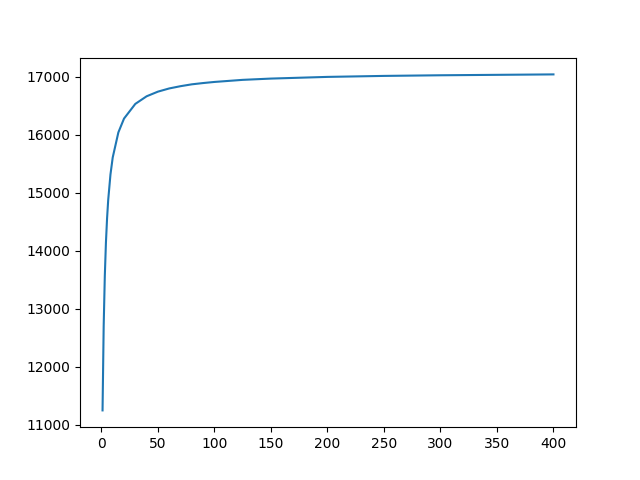

In [7]:
#motor.enable()
#motor.set_target(1.0)

sample_points = [ 400, 300, 250, 200, 150, 125, 100, 90, 80, 70, 60, 50, 40, 30, 20, 15, 10, 8, 6, 5, 4, 3, 2, 1]
samples = []
for s in sample_points:
    print("Setting downsample to ", s)
    tele.set_downsample(s)
    time.sleep(2.5)
    sample = tele.observable().pipe(ops.first()).run()
    samples.append(sample.values[0])

tele.set_downsample(0)
#motor.set_target(0)
#time.sleep(1.0)
#motor.disable()

fig, ax = plt.subplots()
ax.plot(sample_points, samples)
plt.draw()

In [ ]:

tele.set_downsample(0)
motor.set_target(0)
time.sleep(1.0)
motor.disable()


In [ ]:
sf.disconnect()